*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Regression

TODO: intro

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/chapters/regression.ipynb).

In [305]:
# temporary hack to make autoreload work on Colab
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [306]:
from os.path import basename, exists


def download(url, filename=None):
    if filename is None:
        filename = basename(url)
        
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [307]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp

from utils import decorate, underride

In [308]:
from utils import set_precision

set_precision(4)

## Regression as Minimization

Before we think of regression as a linear algebra problem, let's start with minimization.
Specifically, we'll start with **least squares regression**, which minimizes the sum of squared errors.

As the smallest example, I'll construct a predictor, `x`, and a response variable, `y` -- sometimes called independent and dependent variables.

In [309]:
x = np.array([2, 1, 0]) + 0.1
x

array([2.1, 1.1, 0.1])

In [310]:
intercept, slope = 0.5, 0.8
errors = [-0.1, -0.2, 0.3]

y = intercept + slope * x + errors
y

array([2.08, 1.18, 0.88])

A natural way to visualize this dataset is to plot `y` versus `x`.

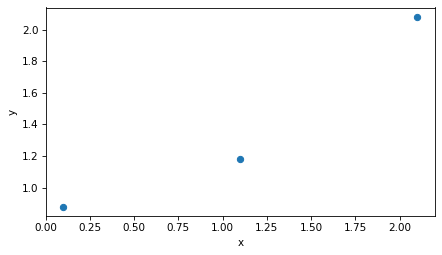

In [311]:
plt.plot(x, y, 'o')
decorate(xlabel='x', ylabel='y')

There's no line that goes through all three points, so we'll find a line of **best fit**.
First we'll construct the **design matrix**, so-called because it represents the design of the regression model.

In this example, the regression model has an intercept and a slope, so the design matrix has two columns: the first, which is all `1`s, corresponds to the intercept; the second, which contains the values of `x`, corresponds to the slope.

In [312]:
from sympy import Matrix

X = np.column_stack((np.ones_like(x), x))
Matrix(X)

Matrix([
[1.0, 2.1],
[1.0, 1.1],
[1.0, 0.1]])

Now the goal is to find the vector of parameters, `beta`, that contains the intercept and slope of the line of best fit.
For this example, we'll start with an arbitrary guess.

In [313]:
beta = np.array([1, 0.4])

To see how good that guess is, we can evaluate the fitted line at each location in `x`.

In [314]:
y_fit = X @ beta

Next we can compute the **residuals**, which are the vertical distances between the actual values, `y`, and the fitted line. 

In [315]:
r = y - y_fit
r

array([ 0.24, -0.26, -0.16])

Here's what that looks like.
The dots are the actual values, the solid line is the not-very-good fit, and the vertical dotted lines show the residuals.

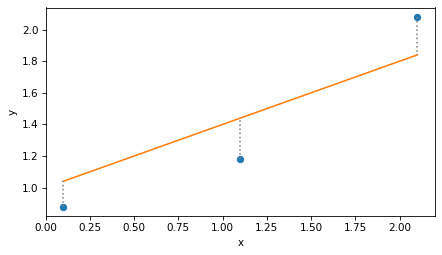

In [316]:
plt.plot(x, y, 'o')
plt.plot(x, y_fit)
plt.vlines(x, y, y_fit, ls=':', color='gray')
decorate(xlabel='x', ylabel='y')

To quantify the goodness of fit, can compute the **residual sum of squares** like this:

In [317]:
np.sum(r**2)

0.1508

Or equivalently, we can compute the dot product of the residuals.

In [318]:
r @ r

0.1508

Here's a function that takes a hypothetical vector of coefficients, `beta`, and returns the residual sum of squares, `rss`.

In [319]:
def rss_func(beta, X, y):
    r = y - X @ beta
    return np.dot(r, r)

Here's the result for the example.

In [320]:
rss_func(beta, X, y)

0.1508

Now we can use `rss_func` with the `minimize` function from SciPy to efficiently search for the value of `beta` that minimizes `rss`.

In [321]:
from scipy.optimize import minimize

result = minimize(rss_func, beta, args=(X, y))
result.message

'Optimization terminated successfully.'

The result is an `OptimizeResult` object; in this case, the `message` attribute indicates that the iterative search converged to a minimum.

The `nfev` attribute is the number of function evaluations -- that is, the number of times `minimize` called `rss_func` with different values of `beta`.

In [322]:
result.nfev

15

And here's the result, which we'll call `beta_hat` because the conventional notation for this result is $\hat{\beta}$, and the caret is almost universally called a "hat".

In [323]:
beta_hat = result.x
beta_hat

array([0.72, 0.6 ])

We can confirm that this value of `beta` yields a lower `rss` than the initial guess. 

In [324]:
rss_func(beta_hat, X, y)

0.0600

If we use `beta_hat` to compute fitted values, the result is called `y_hat`.

In [325]:
y_hat = X @ beta_hat

And here's what the least squares fit looks like.

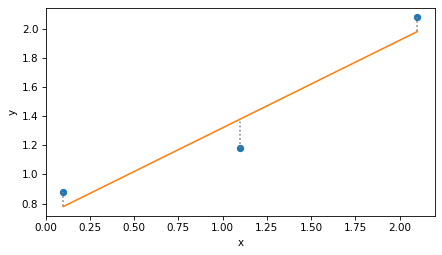

In [326]:
plt.plot(x, y, 'o')
plt.plot(x, y_hat)
plt.vlines(x, y, y_hat, ls=':', color='gray')
decorate(xlabel='x', ylabel='y')

Again, the dotted lines represent the residuals, `r`, and the residual sum of squares is the dot product of `r` with itself.

In [327]:
r = y - y_hat
r @ r

0.0600

To be honest, minimization is not a bad way to solve regression problems, and it generalizes easily to other definitions of "best" and other kinds of regression.
But there's another way: if we write least squares regression as a matrix equation, linear algebra provides an elegant and efficient solution.

## Projection

The key to linear regression is projection.
To see what that means, we'll pull out the columns of the design matrix, `X`, as three-dimensional vectors `v1` and `v2`.

In [328]:
v1, v2 = np.transpose(X)
v1

array([1., 1., 1.])

In [329]:
v2

array([2.1, 1.1, 0.1])

The linear combinations of these vector span a two dimensional plane in three dimensions.
The following figure shows this plane.

It also shows the response variable, `y`, which we can also think of as a vector in three dimensions, as well as the vector of fitted values, `y_hat` -- which looks like the shadow `y` casts onto the plane defined by `v1` and `v2`.

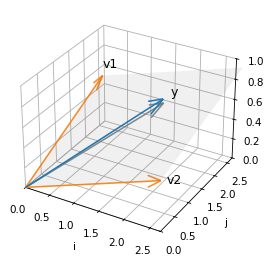

In [330]:
from utils import setup_3D, plot_vectors_3D, label_vectors_3D, plot_plane

setup_3D()
plot_plane(v1, v2, alpha=0.08)
plot_vectors_3D([v1, v2], color='C1')
label_vectors_3D(['v1', 'v2'], [v1, v2])

plot_vectors_3D([y], alpha=1)
label_vectors_3D(['y'], [y], offset=0.08)

plot_vectors_3D([y_hat], color='gray')

lim = [0, 2.7]
decorate(xlim=lim, ylim=lim, zlim=[0, 1], xlabel='i', ylabel='j', zlabel='k')

`y` does not fall in the plane, which means it cannot be expressed as a linear combination of the columns of `X`.

But `y_hat` *does* fall in the plane, because it is a combination of the columns of `X` -- specifically, `y_hat = X @ beta`.

The difference between `y` and `y_hat` is the residual, `r`, which we can also think of as a vector in this space.
This vector has two important properties.
First, the length of `r`, squared, is the residual sum of squares.

In [331]:
from utils import norm

norm(r) ** 2

0.0600

Second, `r` is perpendicular to the columns of `X`, which we can confirm by showing that their dot product is close to zero.

In [332]:
X.T @ r

array([-7.9582e-09, -7.7054e-09])

This result means that `y_hat`, the fitted values that minimize RSS, is the **projection** of `y` onto the plane defined by `v1` and `v2` -- that is, the vector in the plane that's closest to `y`.

This insight is the key to an efficient way to compute `y_hat`, using QR decomposition.

## QR Decomposition

QR composition is similar to LU decomposition, which we used to solve systems of linear equations efficiently.
In LU decomposition, we express a matrix, `A`, as the product of two matrices, one lower-diagonal and one upper-diagonal.

In QR decomposition, we'll express the design matrix, `X`, as the product of two matrices, one **orthonormal** and one upper diagonal.

To explain what an orthonormal matrix is, and why it is useful, we'll use the NumPy function `qr` to compute the decomposition.
In the next section we'll see how this function works.

In [333]:
Q, R = np.linalg.qr(X)

The results are two matrices. `Q` is the same size as `X`.

In [334]:
Q

array([[-5.7735e-01,  7.0711e-01],
       [-5.7735e-01,  5.5511e-17],
       [-5.7735e-01, -7.0711e-01]])

And `R` has the same number of columns as `X`, but it's square and upper triangular.

In [335]:
R

array([[-1.7321, -1.9053],
       [ 0.    ,  1.4142]])

First let's confirm that $Q R = X$.

In [336]:
np.allclose(Q @ R, X)

True

Now if `Q` is orthonormal, the "ortho" part means that the columns are perpendicular to each other, and the "normal" part means the norm of the columns is `1`.
We can confirm both by computing the dot product of the columns with themselves.

In [337]:
Matrix(Q.T @ Q)

Matrix([
[                  1.0, -1.16219581322268e-16],
[-1.16219581322268e-16,                   1.0]])

The off-diagonal elements are close to zero, which confirms that the columns are orthogonal to each other, and the diagonal elements are 1, which confirms that their norm is 1.

But also notice that the product of $Q^T$ and $Q$ is the identity matrix, $I$, which means that $Q^T$ is the inverse of $Q$.
That's true in general: **an orthonomal matrix is its own inverse**.

And that's useful because we can solve the equation 

$Q \beta' = y$ 

by multiplying both sides by $Q^T$, which yields 

$Q^T Q \beta' = Q^T y$, 

which yields 

$\beta' = Q^T y$.

In [338]:
beta_prime = Q.T @ y
beta_prime

array([-2.3902,  0.8485])

And why would we want to solve $Q \beta' = y$?
Because the result is the coordinates of $\hat{y}$ in the span of $Q$.
We can confirm that by multiplying those coordinates by the columns of $Q$.

In [339]:
y_hat = Q @ beta_prime
y_hat

array([1.98, 1.38, 0.78])

And the result is the same as the `y_hat` we computed by minimizing RSS.
Combining the last two steps, we could have computed `y_hat` like this.

In [340]:
y_hat = Q @ Q.T @ y
y_hat

array([1.98, 1.38, 0.78])

Or, instead of multiplying `y` by `Q.T` first, we could multiply `Q` and `Q.T` first.

In [341]:
P = Q @ Q.T
P

array([[ 0.8333,  0.3333, -0.1667],
       [ 0.3333,  0.3333,  0.3333],
       [-0.1667,  0.3333,  0.8333]])

The result is a projection matrix that projects any vector into the span of `Q`.

In [342]:
y_hat = P @ y
y_hat

array([1.98, 1.38, 0.78])

Normally we would not compute `P` explicitly, but it is useful for confirming an important property of `Q`, which is that it has the same span as `X`.
We can show that by projecting the columns of `X` onto `Q`.

In [343]:
P @ X

array([[1. , 2.1],
       [1. , 1.1],
       [1. , 0.1]])

And confirming that the result is `X`.

In [344]:
np.allclose(P @ X, X)

True

Which shows that the plane spanned by `Q` is the same as the plane spanned by `X`.
The following diagram shows two views of

* The columns of `X`, `v1` and `v2`, and the plane they span;

* The columns of `Q`, `q1` and `q2`, and the plane they span.

In [345]:
q1, q2 = Q.T

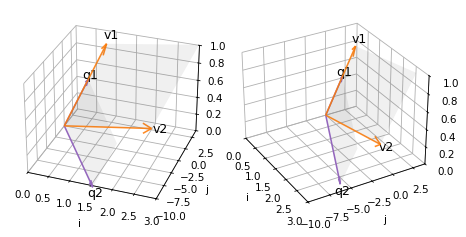

In [346]:
fig, axes = setup_3D(ncols=2)

azimuths = [-70, -30]

for ax, azim in zip(axes, azimuths):
    plt.sca(ax)
    ax.view_init(elev=30, azim=azim, roll=0)

    plot_plane(v1, v2, alpha=0.08)
    plot_plane(-q1, q2, alpha=0.08)
    plot_vectors_3D([v1, v2], color='C1')
    label_vectors_3D(['v1', 'v2'], [v1, v2])

    plot_vectors_3D([-q1, q2], color='C4', alpha=1)
    label_vectors_3D(['q1', 'q2'], [-q1, q2])

    lim = [0, 3]
    decorate(xlim=lim, ylim=[-10, 4], zlim=[0, 1], xlabel='i', ylabel='j', zlabel='k')

Because of the limitations of 3D visualization, it might not be obvious that the two shaded areas are in the same plane -- but they are.

This property is important because it means that projecting `y` onto `Q` is the same as projecting `y` onto `X`, which minimizes RSS -- so we are almost there!

The last step is to use `beta_prime`, which contains the coordinates of `y_hat` in terms of the columns of `Q`, to compute `beta`, which contains coordinates of `y_hat` in terms of the columns of `X`.
Let's see how we do that.

So far we have found $\beta'$ such that $Q \beta' = \hat{y}$, and we want $\beta$ such that $X \beta = \hat{y}$. Setting the left sides equal, we get

$X \beta = Q \beta'$

Replacing $X$ with $QR$ we have

$Q R \beta = Q \beta'$

If we multiply through by $Q^{-1}$, we can cancel $Q$ on both sides, leaving

$R \beta = \beta'$

So we can find $\beta$ by solving this equation.

Since `R` is upper triangular, we can use `solve_triangular`, which is more efficient that the more general `solve` function.
The argument `lower=False` indicates that `R` is upper triangular.

In [347]:
from scipy.linalg import solve_triangular

beta_qr = solve_triangular(R, beta_prime, lower=False)
beta_qr

array([0.72, 0.6 ])

And the result is the same as the `beta` we computed by minimization.

It took a few steps to get here, but now we can write the whole process in just two lines.

In [348]:
def lstsq(X, y):
    Q, R = np.linalg.qr(X)
    beta = solve_triangular(R, Q.T @ y, lower=False)
    return beta

And we get the same result.

In [349]:
lstsq(X, y)

array([0.72, 0.6 ])

SciPy provides a similar function with additional capabilities.

In [350]:
import scipy

beta, _, rank, _ = scipy.linalg.lstsq(X, y, lapack_driver='gelsy')

The argument `lapack_driver='gelsy'` specifies which function to use.
The "ge" part of the name indicates that the function works with general matrices -- not necessarily symmetric, for example.
The "ls" part means it computes a least squares fit.
And "y" indicates the variant that uses QR decomposition.

The first return value is `beta` again.

In [351]:
beta

array([0.72, 0.6 ])

The second and fourth return values are used by other functions, but not `gelsy`.
And the third return value is the rank of the design matrix, which is usually the number of columns in `X`.

In [352]:
rank

2

If the columns are dependent -- that is, if some are linear combinations of others -- the rank might be lower.
We'll see an example of that soon, but first we have a loose end to tie up: how do we compute the QR decomposition?

## Orthonormalization

QR decomposition provides an efficient way to compute a least squares fit.
Now let's see how to do the decomposition.
The process turns out to be simpler than you might expect.

We'll start by unpacking the columns of `X`.

In [353]:
from utils import norm, normalize

v1, v2 = X.T

Now the goal is to find two orthogonal unit vectors, `q1` and `q2`, that span the same plane as `v1` and `v2`.
To compute `q1` we'll compute a unit vector with the same direction as `v1`.

In [354]:
q1 = normalize(v1)
q1

array([0.5774, 0.5774, 0.5774])

To compute `q2`, we'll subtract from `v2` the part of of `v2` parallel to `q1`, leaving only the part of `v2` perpendicular to `q1` (which you might recognize as the vector rejection).

In [355]:
from utils import vector_projection

v2_perp = v2 - vector_projection(v2, q1)

Then we normalize the perpendicular part.

In [356]:
q2 = normalize(v2_perp)
q2

array([ 0.7071,  0.    , -0.7071])

If we pack `q1` and `q2` into a matrix, we get the same `Q` computed by NumPy.

In [357]:
Q = np.column_stack([q1, q2])
Q

array([[ 0.5774,  0.7071],
       [ 0.5774,  0.    ],
       [ 0.5774, -0.7071]])

And we can confirm that `Q.T @ Q = I`, which means that `Q` is orthonormal.

In [358]:
Q.T @ Q

array([[ 1.0000e+00, -1.7796e-17],
       [-1.7796e-17,  1.0000e+00]])

The process we just followed is called **Gram-Schmidt orthonormalization**.
If there are more than two vectors we can repeat the process.
For the third vector, we subtract off the parts parallel to `q1` and `q2`, and normalize what's left.

The following function implements this process for a matrix with any number of columns.

In [359]:
def gram_schmidt(X):
    basis = []
    for v in X.T:
        for q in basis:
            v = v - vector_projection(v, q)
        basis.append(normalize(v))
    return np.transpose(basis)

And we can confirm it works for `X`.

In [360]:
gram_schmidt(X)

array([[ 0.5774,  0.7071],
       [ 0.5774,  0.    ],
       [ 0.5774, -0.7071]])

The previous function is meant to demonstrate the process clearly, but it only computes `Q`.
The following function also computes `R`, so it is a little more complicated.

In [361]:
def gram_schmidt(X):
    m, n = X.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))

    for j in range(n):
        v = X[:, j]
        for i in range(j):
            R[i, j] = X[:, j] @ Q[:, i]
            v = v - R[i, j] * Q[:, i]
            
        R[j, j] = norm(v)
        Q[:, j] = v / R[j, j]
    
    return Q, R

In `R`, the off-diagonal element of `R[i, j]` records the scalar projection of column `j` from `X` into column `i` from `Q`.
And the diagonal element `R[j, j]` records the factor used to normalize column `j` from `Q`.

In [362]:
Q, R = gram_schmidt(X)

Let's confirm that this function computes the same `R` we got from NumPy.

In [363]:
R

array([[1.7321, 1.9053],
       [0.    , 1.4142]])

And that `Q R = X`.

In [364]:
np.allclose(Q @ R, X)

True

That's it! Computing the QR decomposition is efficient, and not especially complicated.

At this point, you might be tired of the small example we've been working with.
So let's see what we can do with real data.

## Multiple Regression

Do people get more conservative as they get older?
To find out, we'll use data from the General Social Survey (GSS) to explore the relationship between political ideology and age, also considering changes over time and differences between generations.

We'll use **multiple regression**, which involves more than one predictor, and we'll see the problems that arise if the predictors are strongly correlated.

The following cell downloads the data.

In [365]:
download('https://github.com/AllenDowney/GssExtract/raw/main/data/interim/gss_extract_2024_1.hdf')

I have prepared an excerpt of GSS data collected between 1974 and 2024, which we can read into a Pandas `DataFrame`.

In [366]:
gss = pd.read_hdf('gss_extract_2024_1.hdf')
gss.shape

(75699, 62)

The `DataFrame` contains one row for each of the 75,699 respondents who have participated in the GSS, and one column for each of the variables in this excerpt.

We'll select only the columns we need for this example and drop any rows with missing data in those columns.

In [367]:
columns = ['polviews', 'year', 'cohort']
subset = gss.dropna(subset=columns)[columns]

The `year` column records the year each respondent was interviewed, and the `cohort` column records their year of birth (sometimes called "birth cohort").
So we can compute the age of each respondent when they were interviewed.

In [368]:
subset['age'] = subset['year'] - subset['cohort']

`polviews` records responses to this question

> We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?


The responses are one of seven categories.

| Number | Political Ideology |
|--------|-------------------|
| 1 | Extremely liberal |
| 2 | Liberal |
| 3 | Slightly liberal |
| 4 | Moderate, middle of the road |
| 5 | Slightly conservative |
| 6 | Conservative |
| 7 | Extremely conservative |

The `describe` method computes summary statistics for these variables.

In [369]:
subset.describe()

,polviews,year,cohort,age
count,65239.0000,65239.0000,65239.0000,65239.0000
mean,4.1086,1999.9547,1954.8059,45.1488
std,1.4057,15.2522,21.9236,17.2269
min,1.0000,1974.0000,1885.0000,18.0000
25%,3.0000,1987.0000,1941.0000,31.0000
50%,4.0000,2000.0000,1956.0000,43.0000
75%,5.0000,2014.0000,1969.0000,58.0000
max,7.0000,2024.0000,2006.0000,90.0000


The average of `polviews` is 4.1, which is close to "middle of the road".
Higher numbers are more conservative, and lower numbers are more liberal.

The range of `year` is from 1974 to 2024.
The range of `cohort` is from 1885 to 2006.
The range of `age` is from 18 to 90.

We can use least squares regression to see how the responses are related to age and other variables.
First we'll assign the values of the response variable to `y`.

In [370]:
response = 'polviews'
y = subset[response]

For the first version of the model we'll select `age` as the only predictor.

In [371]:
predictor = 'age'
means_age = subset.groupby(predictor)[response].mean()

We can get a sense of the relationship between these variables by plotting the mean of the response variable in each age group.

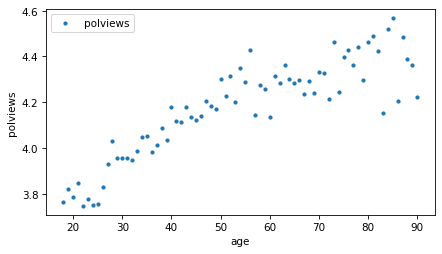

In [372]:
means_age.plot(style='.')
decorate(xlabel=predictor, ylabel=response)

The average increases with age, which means that older people consider themselves more conservative.
But the difference is not very big -- the average among people in their 20s, when they were interviewed, is only slightly left of center, and people in their 90s are about halfway between "middle of the road" and "slightly conservative", on average. 

Let's fit a line to this data.
We'll use `add_constant` to make a design matrix, `X`, that contains the single predictor and a columns of ones.

In [373]:
from utils import add_constant

predictors = [predictor]
X = add_constant(subset[predictors])
X.shape

(65239, 2)

And we'll use SciPy to compute the least squares fit.

In [374]:
beta, _, rank, _ = scipy.linalg.lstsq(X, y, lapack_driver='gelsy')
rank, beta

(2, array([3.6416, 0.0103]))

The rank is `2`, which indicates that the two columns of `X` are independent.

We can interpret the elements of `beta` as an intercept and slope.
The slope is about 0.01, which means that a difference of one year in age is associated with a difference of 0.01 in the average response.
The intercept is the value of the fitted line when `age=0` -- but the fitted line doesn't mean much in this part of the domain.

It makes more sense to evaluate the fitted line over the relevant range of ages, from 18 to 90.

In [375]:
fit_x = np.arange(18, 90)
fit_y = add_constant(fit_x) @ beta

Here's what the line looks like compared to the data.

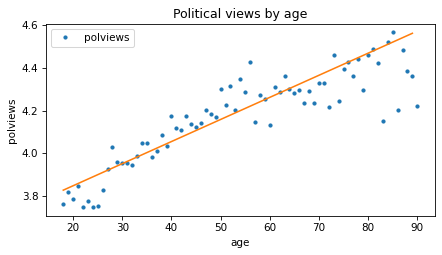

In [376]:
means_age.plot(style='.')
plt.plot(fit_x, fit_y)

decorate(xlabel=predictor, ylabel=response, title='Political views by age')

Based on these results, it seems like people might get more conservative as they get older, but let's also see if there's a relationship with year of birth -- that is, `cohort`.

First, let's put the steps we just followed into a function.

In [377]:
def fit_model(df, response, predictors, fit_x):
    # group means by the first predictor
    means = df.groupby(predictors[0])[response].mean()

    # response and design matrix
    y = df[response]
    X = add_constant(df[predictors])

    # least squares fit
    beta, _, rank, _ = scipy.linalg.lstsq(X, y, lapack_driver='gelsy')

    # fitted values for new X
    fit_y = add_constant(fit_x) @ beta

    # condition number of design matrix
    cond_number = np.linalg.cond(X)

    return RegressionResult(means, cond_number, rank, beta, fit_y)

`fit_model` takes as a parameters the `DataFrame`, the response variable, a list of predictors, and a range of `x` values where it should evaluate the fitted line.

* It uses `groupby` to compute the average of the response variable as a function of the first predictor.

* Then it extracts `y`, makes the design matrix, `X`, and computes the least squared fit.

* It evaluates the fitted line over the given range, `fit_x`.

* It also computes the condition number of `X`, which I'll explain soon.

It returns all of the results in a `RegressionResult` object.

`RegressionResult` is a `dataclass`, which is a Python object that contains a specified set of attributes.

In [378]:
from dataclasses import dataclass

@dataclass
class RegressionResult:
    means: np.ndarray
    cond_number: float
    rank: int
    beta: np.ndarray
    fit_y: np.ndarray

Here's how we can use this function to compute a least squares fit of `polviews` as a function of `age`, again, and save the results.

In [379]:
result_age = fit_model(subset, response, [predictor], fit_x)
result_age.beta

array([3.6416, 0.0103])

Now here's a least squares fit of `polviews` as a function of `cohort`, evaluated over the range of birth years from 1880 to 2010.

In [380]:
predictor = 'cohort'
fit_x = np.arange(1880, 2010)
result_cohort = fit_model(subset, response, [predictor], fit_x)
result_cohort.beta

array([ 1.6354e+01, -6.2643e-03])

The following function takes the regression results and plots the fitted line along with the data.

In [381]:
color_map = {
    'age': 'C0',
    'year': 'C2',
    'yearc': 'C2',
    'cohort': 'C4',
}

def plot_result(response, predictor, result, fit_x):
    result.means.plot(style='.', color=color_map[predictor])
    plt.plot(fit_x, result.fit_y, color='C1')

    decorate(xlabel=predictor, 
             ylabel=response, 
             title=f'{response} by {predictor}')

Here's what the results look like for `polviews` as a function of `cohort`.

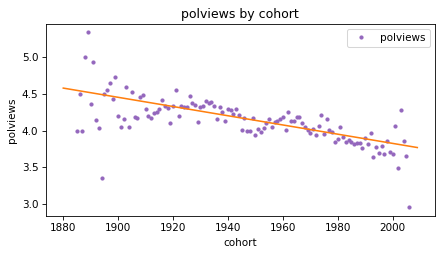

In [382]:
plot_result(response, predictor, result_cohort, fit_x)

The slope of the line is negative, which means that people born earlier are more likely to say they are conservative, compared to people born later.

Based on the results so far, we can't tell whether people get more conservative as they age, or whether older people are more conservative because they were born earlier.
We'll come back to this question, but first let's look at the third predictor, `year`.

## A Quadratic Model

So far we've computed least squares fits with `age` and `cohort` as predictors.
Now let's do the same with `year`.
We'll see that a straight line doesn't fit the data well, so we'll try fitting a parabola.

Here's the least squares fit of `polviews` as a function of `year`.

In [383]:
predictor = 'year'
fit_x = np.arange(1974, 2025)
result_year = fit_model(subset, response, [predictor], fit_x)
result_year.beta

array([3.5988e+00, 2.5495e-04])

And here's the fitted line along with the data.

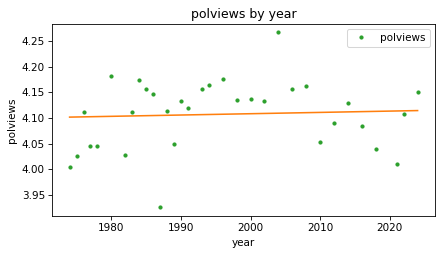

In [384]:
plot_result(response, predictor, result_year, fit_x)

The fitted line is almost flat, which suggests that there is little or no change over time, but we can see that the line does not fit the data very well.
If there is a relationship between `polviews` and `year`, it seems to be **nonlinear**, increasing until some time between 1990 and 2000, and decreasing afterward.

Instead of fitting a straight line to the data, we can fit a parabola.
First we'll compute a new column that contains the values of `year` squared.

In [385]:
subset['year2'] = subset['year'] ** 2

Next we'll run a regression with `year` and `year2` as predictors.
Because we have two predictors, we'll need `fit_X` to be a matrix with two columns.
The first contains a range of dates from 1970 to 2024; the second contains those values squared.

In [386]:
fit_x0 = np.arange(1974, 2025)
fit_x1 = fit_x0 ** 2
fit_X = np.column_stack([fit_x0, fit_x1])

Now we can compute a least squares fit with two predictors.

In [387]:
predictors = ['year', 'year2']
result_year2 = fit_model(subset, response, predictors, fit_X)
result_year2.rank

3

The rank is `3` now, because the design matrix contains two predictors and a column of ones.

If we represent the columns of `X` symbolically as $1$, $x$, and $x^2$, 
and the elements of `beta` as $\beta_0$, $\beta_1$, and $\beta_2$, we can express the dot product of `X` and `beta` like this. 

In [388]:
import sympy as sp

beta = sp.symbols('beta_0 beta_1 beta_2')
x = sp.symbols('x')

np.dot([1, x, x**2], beta)

beta_0 + beta_1*x + beta_2*x**2

That is the equation of a parabola.
Here are the estimated coefficients.

In [389]:
result_year2.beta

array([-5.6547e+02,  5.6937e-01, -1.4228e-04])

The third element (the coefficient of $x^2$) is negative, which indicates that the parabola curves downward.
And if we plot the fitted curve, we can see that it does.

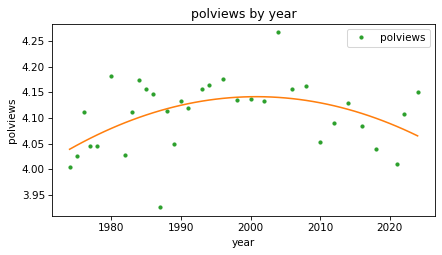

In [390]:
plot_result(response, predictors[0], result_year2, fit_x0)

This model fits the data better than the straight line.
It seems that people were a little more likely to consider themselves conservative in the 1990s and 2000s, but more recently that trend has reversed.

In the next section we'll get back to the question we started with -- as people get older, do they get more conservative?

## Age, Period, Cohort

So far we have modeled the response variable as a function of age, time period (year), and cohort (year of birth).
Now let's see how these predictors interact with each other.
This kind of modeling is called **age-period-cohort** analysis.

First let's try a model with `age` and `cohort` as predictors.

In [391]:
predictors = ['age', 'cohort']
fit_x0 = np.arange(18, 90)
fit_x1 = np.full_like(fit_x0, 2000)
fit_X = np.column_stack([fit_x0, fit_x1])

result = fit_model(subset, response, predictors, fit_X)
result.rank

3

The rank of this model is 3 because the design matrix has three columns and they are independent.

Because this model includes more than one predictor, it is a **multiple regression**, as opposed to a model with only one predictor, which is a **simple regression**.

To visualize the results, we'll consider three cohorts, people born in 1920, 1960, and 2000.
For each cohort, we'll compute a fitted line over a range of ages.

In [392]:
cohorts = [1930, 1960, 1990]
fits = {}

for cohort in cohorts:
    fit_x1 = np.full_like(fit_x0, cohort)
    fit_X = np.column_stack([fit_x0, fit_x1])

    result = fit_model(subset, response, predictors, fit_X)
    fits[cohort] = result.fit_y

Here's what the lines look like for the three cohorts.

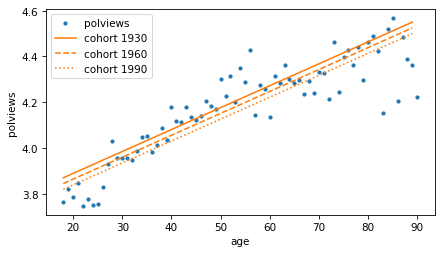

In [393]:
means_age.plot(style='.', color='C0')
style_map = dict(zip(cohorts, ['-', '--', ':']))
   
for cohort, fit_y in fits.items():
    plt.plot(fit_x0, fit_y, style_map[cohort], color='C1', label=f'cohort {cohort}')

decorate(xlabel=predictors[0], ylabel=response)

In each cohort, it looks like older people are more conservative than younger people (or at least more likely to say they are).
But reading the lines from top to bottom, each cohort is a little less conservative than the previous one.

We can see the second effect more clearly if we make a model with `year`, `year2`, and `cohort` as predictors.

In [394]:
predictors = ['year', 'year2', 'cohort']
fit_x0 = np.arange(1974, 2025)

fits = {}
for cohort in cohorts:
    fit_x1 = fit_x0 ** 2
    fit_x2 = np.full_like(fit_x0, cohort)
    fit_X = np.column_stack([fit_x0, fit_x1, fit_x2])

    result = fit_model(subset, response, predictors, fit_X)
    fits[cohort] = result.fit_y
    
result.rank

4

The rank of the design matrix is `4` because it contains three predictors and a column of ones.

Because it includes both `year` and `year2`, the fitted curves are parabolas when we plot them as a function of time.

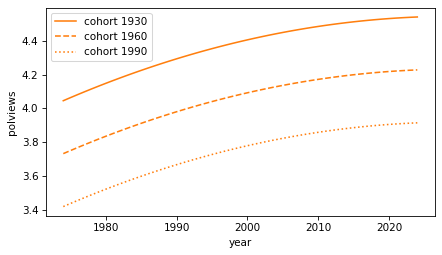

In [395]:
for cohort, fit_y in fits.items():
    plt.plot(fit_x0, fit_y, style_map[cohort], color='C1', label=f'cohort {cohort}')

decorate(xlabel=predictors[0], ylabel=response)

Again, as people get older, they are more likely to say they are conservative.
And each cohort is less conservative than the previous.
But we should interpret this graph with caution, because it extrapolates beyond the data we have -- people born in 1990 were not included in the survey until they were 18 years old in 2018.

Nevertheless, we can conclude that there are two trends happening at the same time: 

* Between cohorts, people born earlier are more conservative, and 

* As they get older, each cohort is more likely to say they are conservative, on average.

If you are curious about this topic, I explored it more deeply in Chapter 12 of [*Probably Overthinking it*](https://probablyoverthinking.it).

But before we go on, I have a warning about a common error.

## Collinearity

When people learn about age-period-cohort analysis, they often attempt something impossible -- a model that includes age, period, *and* cohort.

To see why it's impossible, let's try.

In [ ]:
predictors = ['age', 'cohort', 'year']
fit_x0 = np.arange(18, 90)
fit_x1 = np.full_like(fit_x0, 2000)
fit_x2 = np.full_like(fit_x0, 2018)
fit_X = np.column_stack([fit_x0, fit_x1, fit_x2])

result = fit_model(subset, response, predictors, fit_X)

It's not obvious that something has gone wrong.
And the coefficients are similar to the ones we saw in previous models.

In [397]:
result.beta

array([ 5.3109e+00,  6.6641e-03, -3.7502e-03,  2.9139e-03])

But notice that the rank is only `3`.

In [396]:
result.rank

3

The design matrix has four columns -- three predictors and a column of ones -- but they are not independent.
That's because `age = year - cohort`.
And that's a problem.

To see why, recall that `fit_model` uses the SciPy function `lstsq`, which uses QR factorization.
And QR factorization uses the Gram-Schmitt process.
So let's see what happens when we try to orthogonalize a matrix with dependent columns.

In [398]:
y = subset[response]
X = add_constant(subset[predictors])
Q, R = gram_schmidt(X)

Remember that the columns of `Q` are suppose to be orthogonal, so `Q.T @ Q` should be the identity matrix.

In [399]:
(Q.T @ Q).round(4)

array([[ 1.    ,  0.    , -0.    , -0.007 ],
       [ 0.    ,  1.    , -0.    , -0.0019],
       [-0.    , -0.    ,  1.    ,  1.    ],
       [-0.007 , -0.0019,  1.    ,  1.    ]])

The first three columns are orthogonal to each other, but in the last row and column, the off diagonal elements are not zero, as they should be -- which means that the last column is not orthogonal to the others.
In fact, the last two columns are almost identical, and their dot product is close to one.

This problem is called **collinearity** because these columns in `Q` are co-linear -- that is, they fall on the same line.

TODO: Show how the result is underconstrained orthogonal equations

Fortunately, most statistical software is aware of this problem, and provides a warning when it happens.
For example, here's how we can fit the same model with the `StatsModels` function `OLS` (which stands for "ordinary least squares"):

In [400]:
import statsmodels.api as sm

result = sm.OLS(y, X).fit()

The result object ...

In [401]:
result.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               polviews   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
No. Observations:               65239   F-statistic:                     535.6
Covariance Type:            nonrobust   Prob (F-statistic):          1.89e-231
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3109      0.718      7.399      0.000       3.904       6.718
x1             0.0067      0.000     28.504      0.000       0.006       0.007
x2            -0.0038      0.000    -22.423      0.000      -0.004      -0.003
x3             0.0029      0.000     11.521      0.000       0.002       0.003
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.22e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The argument `slim=True` specifies a reduced summary -- but even so, it contains more information than we need.
In the table, the `coef` column contains the estimated coefficients, which are the same as the ones we computed.

But the notes at the bottom include this warning:

> The smallest eigenvalue is 5.22e-21. This might indicate that there are strong multicollinearity problems or that the design matrix is singular.

Statsmodels computes the eigenvalues of $X^T X$, the matrix that contains the dot products of the columns of $X$ with each other.
The smallest eigenvalue indicates how close the columns are to being linearly dependent.
If that value is close to zero, the matrix is nearly singular -- that is, its columns are nearly dependent.

Another way to say the same thing is that the columns are **multicollinear**, which means that there is some combination of columns that lies on the same line as another column.

In addition to the smallest eigenvalue of $X^T X$, there is another way to detect possible problems with the design matrix, the condition number.

## Condition Number



In [290]:
def condition_number_table(results, index):
    kappas = [result.cond_number for result in results]

    return pd.DataFrame({r'$\kappa$': kappas, 
                         r'$\log \kappa $': np.log10(kappas)}, 
                        index=index)


In [291]:
results = [result_age, result_cohort, result_year, result_year2]
index = ['age', 'cohort', 'year', 'year + year2']
condition_number_table(results, index)

,$\kappa$,$\log \kappa $
age,135.6059,2.1323
cohort,174322.2522,5.2414
year,262262.0771,5.4187
year + year2,77917685753.1958,10.8916


## Orthogonal Equations

In this chapter, we computed the coefficients of a least squares fit using QR decomposition, which is an efficient algorithm that behaves well numerically.
But there is another way to derive and compute a least squares fit, but writing and solving the **orthogonal equations**.
This method is not often used in practice because it is less efficient and the results are less precise.
But it provides another view of how linear regression works.

To review, the goal of a least squares fit is to find a vector of coefficients, $\beta$, that minimizes the residuals, $y - X \beta$.
And we have shown that we can minimize this residual by computing the projection the projection of $y$ onto the space spanned by the columns of $X$, which means that the residual  is orthogonal to the columns of $X$.

Let's check whether that's true for a regressions we ran in a previous section, `polviews` as a  function of `age` and `cohort`.

In [456]:
predictors = ['age', 'cohort']
y = subset[response]
X = add_constant(subset[predictors])
beta, _, rank, _ = scipy.linalg.lstsq(X, y, lapack_driver='gelsy')
beta

array([ 5.3109e+00,  9.5780e-03, -8.3626e-04])

Here are the residuals.

In [457]:
r = y - X @ beta

And here are the dot products of the residuals with the columns of `X`.

In [458]:
X.T @ r

array([-1.7548e-10, -7.9385e-09, -3.4235e-07])

They are close to zero, within the precision we expect for this calculation.
So we've confirmed that $X^T (y - X \beta) = 0$, at least approximately, for the $\beta$ we found.
Turning that around, we can use that equation to solve for $\beta$.

Matrix multiplication is distributive, so we can write that equation as 

$$ X^T y - X^T X \beta = 0 $$

Or, if we rearrange terms, we can write

$$ X^T X \beta = X^T y $$

We can solve this equation by computing the **normal matrix**, $X^T X$.

In [459]:
A = X.T @ X
A

array([[6.5239e+04, 2.9455e+06, 1.2753e+08],
       [2.9455e+06, 1.5234e+08, 5.7400e+09],
       [1.2753e+08, 5.7400e+09, 2.4933e+11]])

And the right hand side of the matrix equation, $X^T y$

In [460]:
b = X.T @ y
b

array([2.6804e+05, 1.2302e+07, 5.2378e+08])

And we can solve the matrix equation for $\beta$.

In [461]:
beta2 = np.linalg.solve(A, b)
beta2

array([ 5.3109e+00,  9.5780e-03, -8.3626e-04])

The result is the same as what we got from QR decomposition, at least approximately.

In [462]:
np.allclose(beta, beta2)

True

In general, the coefficients we get from QR decomposition are more precise than the ones we get by solving the normal equations.
That's because the condition number of the normal matrix, $X^T X$ is the condition number of $X$ squared!

Recall that the condition number of $X$ for this model is already too big.
When we square it, the result is even worse.

In [463]:
np.linalg.cond(X), np.linalg.cond(A)

(257102.2685, 66101576676.7283)

Solving the normal equations roughly doubles the loss of precision, compared to QR decomposition.

## Exercises

### Exercise

Center the predictors and show that it improves the condition number.
Confirm that the intercept is different but the coefficients of the predictors are the same.

In [452]:
subset['age_centered'] = subset['age'] - subset['age'].mean()
subset['cohort_centered'] = subset['cohort'] - subset['cohort'].mean()

In [453]:
predictors = ['age_centered', 'cohort_centered']
y = subset[response]
X = add_constant(subset[predictors])
beta, _, rank, _ = scipy.linalg.lstsq(X, y, lapack_driver='gelsy')
beta

array([ 4.1086e+00,  9.5780e-03, -8.3626e-04])

In [454]:
np.linalg.cond(X)

26.0035

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)